[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/15YmaHoZTMMONDLuCChk2o1JmlYihXhKy?usp=sharing)



# Система рекомендаций фильмов 🎥

Системы рекомендаций фильмов предоставляют пользователям механизм, помогающий классифицировать их по схожим интересам. Необходимо построить векторные представления пользователей и фильмов, используя нейросетевые подходы.

## 1. Данные
Данные были взяты с официального сайта *GroupLens*: https://grouplens.org/datasets/movielens/latest/

Поскольку датасет имеет большую размерность, раздзеление данных на валидационный и тренировочные сеты будет в соотношении 20% и 80% соответственно. 

## 2. Выбор метрики

Поскольку перед нами стоит задача регрессии, в качестве метрики качества можно использовать MSE или RMSE, которые позволяют оценить, насколько близко предсказанные оценки фильмов пользователями соответствуют их реальным оценкам.

## 3. Архитектура нейронной сети
Было прочитанно об архитектуре здесь: https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

В качестве выбора архитектуры нейронной сети, мой выбор пал на модель нейронной коллаборативной фильтрации (NCF), которая используется для рекомендовательных систем. Модель состоит из четырех частей:

1. Эмбеддинги пользователей и фильмов - это способ представления пользователей и фильмов в виде векторов фиксированной длины, который используется для обучения модели.
2. Обобщенная матричная факторизация (GMF) - это часть модели, которая использует умножение эмбеддингов пользователей и фильмов для получения скрытых факторов, которые объясняют взаимодействия пользователей и фильмов.
3. Многослойный перцептрон (MLP) - это часть модели, которая использует скрытые слои для обработки информации об эмбеддингах пользователей и предметов, чтобы получить более высокоуровневые признаки.
4. Слой конкатенации - это часть модели, которая объединяет результаты из GMF и MLP, чтобы получить окончательные предсказания о рекомендациях для пользователя.

### Параметры модели

Для модели NCF будут использоваться следующие параметры:

* Размер встраиваемого поля: 20
* Количество эпох: 5
* Функция потерь: RMSE
* Скорость обучения: 0.01
* Оптимизация: Adam
* Размер Mini-batch: 64


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Установка датасета
!wget -nc https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip -n ml-latest.zip

--2023-05-10 14:25:50--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  56.1MB/s    in 5.0s    

2023-05-10 14:25:56 (52.5 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [4]:
# Загрузка датасетов
movie_df = pd.read_csv("/content/ml-latest/movies.csv")
tags_df = pd.read_csv("/content/ml-latest/tags.csv", parse_dates=["timestamp"])
ratings_df = pd.read_csv("/content/ml-latest/ratings.csv")

In [5]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [6]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  object
dtypes: int64(2), object(2)
memory usage: 33.8+ MB


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


## 👌 Подготовка данных

Чтобы подготовить данные к модели, их необходимо обработать. Для этого, будет сделано следующее:

1. Взять уникальные `id` пользователей. ✅
2. Выбрать в случайном порядке 20% пользователей из датасета `ratings.csv`. ✅
3. Кодирование `userId` и `movieId` по индексам. ✅
4. Разделение данных на тренировочные и валидационные сеты. ✅

In [8]:
# Взятие уникальных id пользователей из датасета ratings.csv
user_Ids = ratings_df.userId.unique().tolist()
num_all_users = len(user_Ids)

In [9]:
print(num_all_users)

283228


In [10]:
# Выбор случайных пользователей из датасета ratings.csv
np.random.seed(42)
random_users_ids = np.random.choice(user_Ids, 
                                    size=int(num_all_users * 0.1),
                                    replace=True)
sample_df = ratings_df.loc[ratings_df["userId"].isin(random_users_ids)]

In [11]:
print(random_users_ids)

[121959 146868 131933 ...  61856  97736 251929]


In [12]:
print(sample_df)

          userId  movieId  rating   timestamp
850            6       10     4.0   832039632
851            6       21     4.0   832039737
852            6       32     5.0   832039879
853            6       47     5.0   832039898
854            6       50     5.0   832039795
...          ...      ...     ...         ...
27752683  283216    59604     3.0  1305141821
27752684  283216    63859     4.5  1305141395
27752685  283216    65142     5.0  1305142195
27752686  283216    68965     0.5  1305142175
27752687  283216    80222     3.0  1305142057

[2699073 rows x 4 columns]


In [13]:
# Кодирование userId по индексам
user_Ids = sample_df["userId"].unique()
num_users = len(user_Ids)

user2user_encoded = {x: i for i, x in enumerate(user_Ids)}
user_encoded2user = {i: x for i, x in enumerate(user_Ids)}
sample_df["user_encoded"] = sample_df["userId"].map(user2user_encoded)

<ipython-input-13-133371e72a7d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["user_encoded"] = sample_df["userId"].map(user2user_encoded)


In [14]:
# Кодирование movieId по индексам
movie_Ids = sample_df["movieId"].unique()
num_movies = len(movie_Ids)
movie2movie_encoded = {x: i for i, x in enumerate(movie_Ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_Ids)}
sample_df["movie_encoded"] = sample_df["movieId"].map(movie2movie_encoded)

<ipython-input-14-f4bebd62918b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["movie_encoded"] = sample_df["movieId"].map(movie2movie_encoded)


In [15]:
print(sample_df)

          userId  movieId  rating   timestamp  user_encoded  movie_encoded
850            6       10     4.0   832039632             0              0
851            6       21     4.0   832039737             0              1
852            6       32     5.0   832039879             0              2
853            6       47     5.0   832039898             0              3
854            6       50     5.0   832039795             0              4
...          ...      ...     ...         ...           ...            ...
27752683  283216    59604     3.0  1305141821         26974           8018
27752684  283216    63859     4.5  1305141395         26974           2650
27752685  283216    65142     5.0  1305142195         26974          14382
27752686  283216    68965     0.5  1305142175         26974          18262
27752687  283216    80222     3.0  1305142057         26974           4134

[2699073 rows x 6 columns]


In [16]:
# Разделение данных на тренировочные и валидационные сеты
from sklearn.model_selection import train_test_split

train, test = train_test_split(sample_df,
                               test_size=0.2,
                               random_state=42)
num_train_users = len(np.unique(train["user_encoded"]))
num_train_movies = len(np.unique(train["movie_encoded"]))

In [17]:
# Небольшая сводка по данным
print(f"Total movies: {num_movies}",
      f"\nMovies in train: {num_train_movies}",
      f"\nMovies not in train: {num_movies - num_train_movies}",
      f"\n",
      f"\nTotal users: {num_users}",
      f"\nUsers in train: {num_train_users}",
      f"\nUsers not in train: {num_users - num_train_users}")

Total movies: 36584 
Movies in train: 33867 
Movies not in train: 2717 
 
Total users: 26975 
Users in train: 26842 
Users not in train: 133


## 🔶 Создание модели

Теперь, когда данные обработаны, можно заниматься разработкой модели.

Для этого, необходимо сделать несколько шагов:
1. Импортирование библиотек для создания модели. ✅
2. Создание функции, которая выстраивает архитектуру модели. ✅
3. Вывод итоговой информации о модели. ✅

In [18]:
# Импортирование библиотек для создания модели
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Add, Dense, Dropout, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error

In [19]:
def NCF_model(embed_size=10,
              drop_out_prob=0.2):
  """
  Эта функция создаёт NCF модель. На входе, модель принимает число размера встраиваемого слоя, и число с плавающей точкой в качестве вероятности выпадения.
  Резулььтатом функции является созданная NCF модель с настроенными слоями.
  """
  # Определение пробела для встраивания входных данных
  movie_input = Input(shape=[1], name="movie-input")
  user_input = Input(shape=[1], name="user-input")

  # MLP эмбеддинги для пользователей и фильмов
  movie_embedding_mlp = Embedding(num_movies, embed_size, name="movie-embedding-mlp")(movie_input)
  movie_vec_mlp = Flatten(name="flatten-movie-mlp")(movie_embedding_mlp)

  user_embedding_mlp = Embedding(num_users, embed_size, name="user-embedding-mlp")(user_input)
  user_vec_mlp = Flatten(name="flatten-user-mlp")(user_embedding_mlp)

  # MF эмбеддинги для пользования и фильмов
  movie_embedding_mf = Embedding(num_movies, embed_size, name='movie-embedding-mf')(movie_input)
  movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

  user_embedding_mf = Embedding(num_users, embed_size, name='user-embedding-mf')(user_input)
  user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

  # MLP слои
  concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
  concat_dropout = Dropout(drop_out_prob)(concat)

  fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
  fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
  fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

  fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
  fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
  fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

  # Предсказания из двух слоев
  pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
  pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)
  combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')

  # Итоговое предсказание
  result = Dense(1, name='result', activation='relu')(combine_mlp_mf)
  model = Model([user_input, movie_input], result)
  model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

  return model

In [20]:
# Создание модели
model = NCF_model()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
# Данные о модели
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       365840      ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       269750      ['user-input[0][0]']         

## 🔧 Обучение модели 

Теперь, когда модель создана, можно её обучить на тренировочном сете, с размером встраиваемого слоя 25 и с вероятностью по умолчанию, которая указана в функции для создания модели. 

In [22]:
# Создание модели
model = NCF_model(embed_size=25)
history = model.fit([train.user_encoded, train.movie_encoded], 
                    train.rating, 
                    epochs=5)

Epoch 1/5
67477/67477 [==============================] - 431s 6ms/step - loss: 0.8600
Epoch 2/5
67477/67477 [==============================] - 426s 6ms/step - loss: 0.7928
Epoch 3/5
67477/67477 [==============================] - 421s 6ms/step - loss: 0.7731
Epoch 4/5
67477/67477 [==============================] - 423s 6ms/step - loss: 0.7614
Epoch 5/5
67477/67477 [==============================] - 440s 7ms/step - loss: 0.7527


AttributeError: ignored

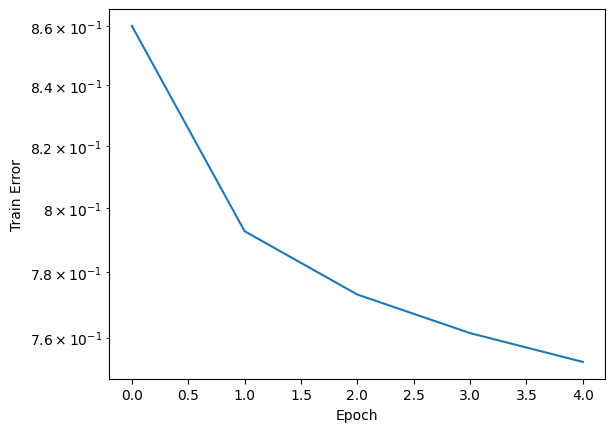

In [23]:
pd.Series(history.history["loss"]).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

## ⭐ Оценка модели

Оценка модели производится по метрике RMSE. Оценка будет производиться на валидационном сете.

In [24]:
# Предсказание рейтинга на валидационном сете
y_pred = np.round(model.predict([test.user_encoded, test.movie_encoded]), decimals=2)
y_true = test["rating"]

16870/16870 [==============================] - 43s 3ms/step


In [25]:
from sklearn.metrics import mean_squared_error
print(f"Test RMSE: {mean_squared_error(y_true, y_pred)}")

Test RMSE: 0.7984851067805789


In [26]:
# Создание датафрейма с предсказанными данными
data = {
    "prediction": y_pred.tolist(),
    "true_value": y_true.values.tolist()
}
test_pred_df = pd.DataFrame(data)
test_pred_df.head()

,prediction,true_value
0,[4.289999961853027],4.0
1,[3.4800000190734863],1.0
2,[3.5799999237060547],4.0
3,[4.090000152587891],4.0
4,[3.8499999046325684],3.0


Подсчитаем количество оценок для всех пользователей.

In [27]:
user_counts = sample_df.groupby('userId').size()

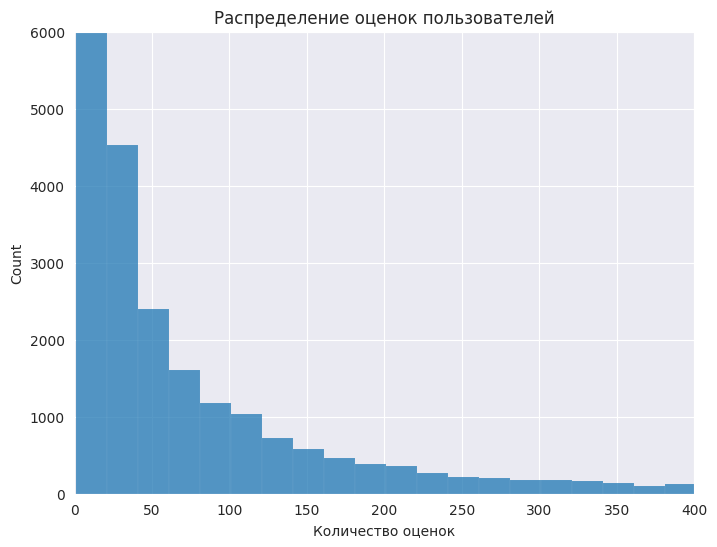

In [30]:
# Построение графика распределения оценок
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('darkgrid')

sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,6000], xlim=[0,400], title='Распределение оценок пользователей', xlabel='Количество оценок');

Классифицируем пользователей на основе распределения оценок. Это необходимо, чтобы просчитать метрику RMSE для всех групп пользователей.

In [32]:
# Создание словаря с количеством оценок для каждой категории
active_levels = ['<10', '10-20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<10'] = user_counts[user_counts < 10]
user_counts_levels['10-20'] = user_counts[(user_counts >= 10) & (user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

In [33]:
user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = sample_df[sample_df['userId'].isin(indices)]
    y_true = pred_df['rating']
    y_pred = model.predict([pred_df['user_encoded'], pred_df['movie_encoded']])
    user_level_rmse.append(mean_squared_error(y_true, y_pred))

58109/58109 [==============================] - 109s 2ms/step


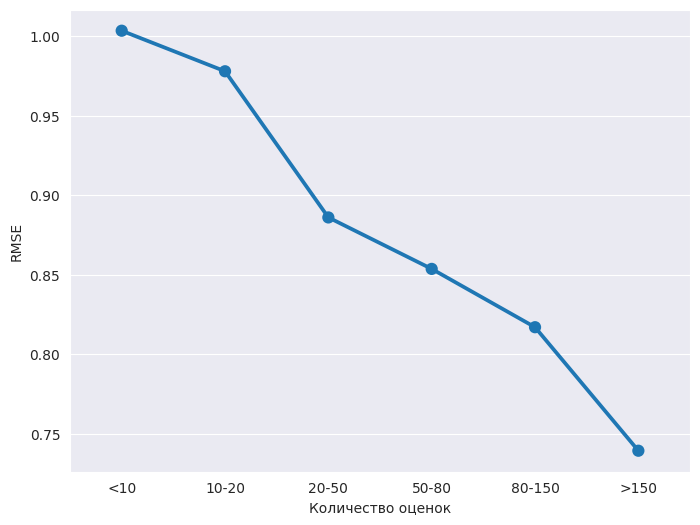

In [36]:
# Построение графика распределения оценок по RMSE для каждой категории
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('darkgrid')
sns.pointplot(y=user_level_rmse, x=np.arange(6))
ax.set(xticklabels=active_levels, xlabel='Количество оценок', ylabel='RMSE');

### Кросс-Валидация на валидационном сете

Выборкой для кросс-валидации будет являться 100000 экземпляров данных из тренировочных данных в качестве валидационного сета.

In [37]:
from sklearn.model_selection import KFold

valid_df_size = 100000
valid_df = train.sample(n=int(valid_df_size), 
                        replace=False, 
                        random_state=42)

embedding_layers = [5, 10, 15, 20, 25, 30]

In [38]:
# Создание функции для обучения модели с кросс-валидацией
def NCF_cross_validation(cv_df, 
                         eb_layers, 
                         drop_prob=0.2, 
                         epoch=3, 
                         n_split=3):
    """
    Эта функция создает результат кросс-валидации на валидационном сете. В качестве входных данных функция 
    принимает набор проверочных данных, список размеров слоя встраивания, вероятность отсева, количество эпох, количество кратностей.
    Функция возвращает спискок кросс-валидации для каждого параметра.
    """
    
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'movie_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'movie_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['movie_encoded']], cv_train_y, epochs=epoch)
            
            curr_loss = model_cv.evaluate([cv_df['user_encoded'], cv_df['movie_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [39]:
result = NCF_cross_validation(valid_df, 
                              embedding_layers)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
2084/2084 [==============================] - 15s 6ms/step - loss: 1.2062
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9103
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.6984
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1944
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9093
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5386
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2263
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8729
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5342
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2036
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.8763
Epoch 3/3
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5143
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1875
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9098
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5302
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2169
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8904
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5334
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1952
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.8852
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5284
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2362
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.8666
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5318
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2087
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9033
Epoch 3/3
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5276
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1951
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.8397
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5146
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 6ms/step - loss: 1.1972
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9176
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5468
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2104
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9037
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5078
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2447
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8841
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5431
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1951
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8390
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5085
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2368
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8704
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5314
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2057
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8834
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5539
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2026
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.9097
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5422
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.2096
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.8915
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 0.5168


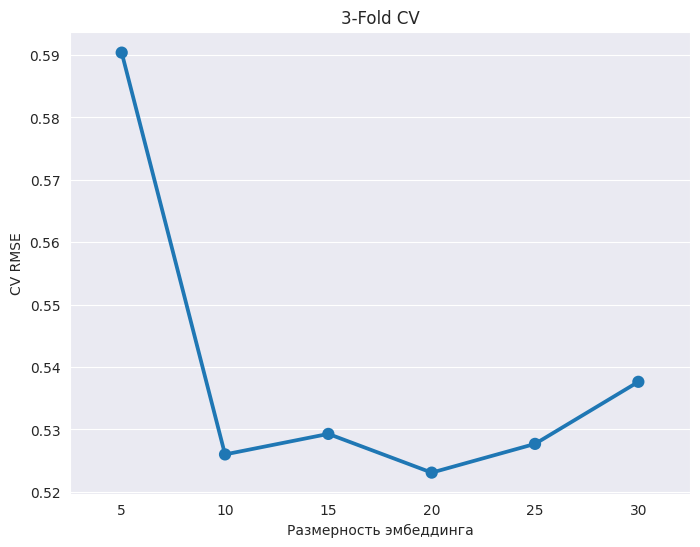

In [41]:
# Построение графика
cv_result_df = pd.DataFrame({'cv_rmse': result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('darkgrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Размерность эмбеддинга', ylabel='CV RMSE', title='3-Fold CV');

### Рекомендация топ 10 фильмов для пользователя

После всех действий, можно попробовать сделать топ 10 рекомендаций для пользователя, в зависимости от его предыдущих оценок. Для этого, будет удобно создать функцию, которая выводит названия топ 10 фильмов.


In [42]:
def recommendation_top_10(rec_model, client_id, top_k=10):
    client_encoded = user2user_encoded[client_id]
    movie_watched = sample_df[sample_df['userId'] == client_id]['movieId'].values
    
    movie_poll_encoded = []
    for item in movie_Ids:
        if not np.isin(item, movie_watched):
            movie_poll_encoded.append(movie2movie_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_df.set_index('movieId'))

    return top_movie_rec

In [43]:
# Проверка функции
client_id = int(np.random.choice(user_Ids, 1))
print(f"Recommended films for user: {client_id}")
recommendation_top_10(model, client_id)

Recommended films for user: 276525
1143/1143 [==============================] - 2s 2ms/step


,prediction,title,genres
movieId,,,
4312,4.729155,Himalaya (Himalaya - l'enfance d'un chef) (1999),Adventure|Drama
1860,4.724628,Character (Karakter) (1997),Drama
159817,4.719886,Planet Earth (2006),Documentary
7136,4.647678,Stolen Kisses (Baisers volés) (1968),Comedy|Drama|Romance
2879,4.629609,Armour of God II: Operation Condor (Operation ...,Action|Adventure|Comedy
3645,4.592619,Cleo from 5 to 7 (Cléo de 5 à 7) (1962),Drama
55721,4.498368,Elite Squad (Tropa de Elite) (2007),Action|Crime|Drama|Thriller
4614,4.495929,Kickboxer (1989),Action
136447,4.488607,George Carlin: You Are All Diseased (1999),Comedy
